# ** Project 1, Hurricane Trajectory Predictions with ENSO-based Frequency Analysis**

Group 2 (Zhi Wang, Kihyun Jye, Kefeng Shi)

# 1.Overview

This project aims to analyze and predict the movement of hurricanes using **machine learning techniques**. The patterns of tropical cyclones (hurricanes) in the **North Atlantic Ocean basin** have considerable uncertainty, and predicting their trajectories is essential, especially considering the region’s vulnerability to hurricanes. Coastal cities like **Miami, New Orleans, Houston, and New York** are heavily affected by hurricanes, and accurate trajectory predictions are crucial for timely evacuations, reducing deaths and injuries.

**ENSO (El Niño and La Niña)** is correlated with hurricane patterns. **El Niño** increases **wind shear** over the Atlantic, reducing hurricane activity, while **La Niña** reduces wind shear, creating more favorable conditions for hurricanes. Understanding how **ENSO-driven shifts** influence hurricane genesis, intensity, and preferred tracks can significantly improve risk assessments for vulnerable regions.

In this project, we focus on **short-term hurricane track shifts** using a **Time Sequence approach** and examine how **ENSO phases** (El Niño and La Niña) influence hurricane **occurrence** and **movement patterns**. We aim to **predict** the hurricane movement directions using a **regression model (XGBoost)** that integrates time-dependent hurricane trajectory predictions with **ENSO-based frequency analysis**.

# 2.Problem Statement 

Tropical cyclones, or hurricanes, are exhibiting a trend of **poleward migration**, shifting their tracks toward **higher latitudes**. Understanding and predicting this phenomenon is critical for assessing future climate risks.

Our initial goal was to predict **hurricane poleward migration** using historical track data (latitude, longitude, speed, and direction). However, preliminary experiments revealed strong **autocorrelation** between the latitude and longitude parameters, making it difficult to isolate the drivers of poleward shifts

 **This notebook provides a structured approach to:**

- **Working with xarray datasets** containing **hurricane track data**.
- **Constructing ENSO-related input features** to enhance hurricane trajectory predictions.
- **Extracting key features** like **storm speed**, **direction**, and **seasonal variations**.
- **Implementing machine learning models**, specifically **XGBoost**, to predict **shifts in hurricane tracks**.
- **Evaluating model performance** and fine-tuning hyperparameters using **Randomized Search** to improve predictions.

# 3. Data Sources & Preprocessing 

The data used in this model includes the NA_data.nc that was provided to the students during previous lectures, the SOI data from NOAA is used as well (https://www.ncei.noaa.gov/access/monitoring/enso/soi).

**Data Preprocessing Steps:**

- **SOI Data**:  
  - The SOI data was **fetched from the NOAA website** and cleaned for any **missing or invalid values**.  
  - It was then **transformed** to calculate **annual averages** and **hurricane season averages** (June to November).

- **Hurricane Data**:  
  - The **hurricane data** was processed to ensure there were **no missing values** in **latitude** and **longitude**.
  - The data was **aligned** to the corresponding **ENSO phases** for further analysis.


In [4]:
import requests
import pandas as pd
from io import StringIO

def process_soi_data(url):
    # Fetch data
    response = requests.get(url)
    raw_text = response.text.split("\n")

    # Locate first "YEAR" occurrence (start of Anomaly table)
    start_index = next(i for i, line in enumerate(raw_text) if "YEAR" in line)
    end_index = next(i for i, line in enumerate(raw_text[start_index+1:], start_index+1) if "YEAR" in line)

    # Extract only the first table (Anomaly data)
    raw_data = raw_text[start_index:end_index]

    # Convert text into pandas DataFrame
    cleaned_data = "\n".join(raw_data)
    df = pd.read_csv(StringIO(cleaned_data), sep='\\s+', engine='python', dtype=str)  # Load everything as string first

    # Ensure correct column names
    df.columns = ["Year", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    # Fix issue: Extract only first four characters from "Year"
    df["Year"] = df["Year"].astype(str).str[:4]  # Keep only valid 4-digit years
    df = df[df["Year"].str.isnumeric()]  # **Ensure all values are numeric**
    df["Year"] = df["Year"].astype(int)  # Convert to integer

    # Remove invalid future years (keep only data up to 2024)
    df = df[df["Year"] <= 2024]

    # Convert SOI values from string to float
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors="coerce")  # Convert to float, set invalids to NaN

    # Compute annual SOI mean
    df["SOI_Annual"] = df.iloc[:, 1:].mean(axis=1, skipna=True)

    # Compute seasonal SOI mean (June to November)
    df["SOI_Hurricane_Season"] = df[["Jun", "Jul", "Aug", "Sep", "Oct", "Nov"]].mean(axis=1, skipna=True)

    # Select only Year, SOI_Annual, and SOI_Hurricane_Season columns
    df = df[["Year", "SOI_Annual", "SOI_Hurricane_Season"]]

    return df

# Load and process SOI data
soi_url = "https://www.cpc.ncep.noaa.gov/data/indices/soi"
soi_data = process_soi_data(soi_url)

# Verify output
print(soi_data.head())
print(soi_data.dtypes)  # Ensure all columns have correct data types


   Year  SOI_Annual  SOI_Hurricane_Season
0  1951   -0.458333             -1.083333
1  1952   -0.041667              0.383333
2  1953   -0.683333             -0.716667
3  1954    0.733333              0.600000
4  1955    1.691667              2.316667
Year                      int64
SOI_Annual              float64
SOI_Hurricane_Season    float64
dtype: object


# 4. Feature Engineering: Constructing Input Features for Prediction

## Now that we have the hurricane track data and ENSO data (SOI_Hurricane_Season) processed, we will create the input features (X) and target variables (y) for training our model.

In [9]:
import numpy as np
import xarray as xr
import pandas as pd

# Load the NetCDF dataset 
file_path = "NA_data.nc"  
ds = xr.open_dataset(file_path)

# Extract relevant variables
lat = ds["lat"].values  # Hurricane latitude
lon = ds["lon"].values  # Hurricane longitude
storm_speed = ds["storm_speed"].values  # Hurricane wind speed
storm_dir = ds["storm_dir"].values  # Hurricane movement direction
season = ds["season"].values  # Year of the hurricane

# Load SOI data (ENSO influence)
soi_url = "https://www.cpc.ncep.noaa.gov/data/indices/soi"
soi_data = process_soi_data(soi_url)  # Function defined in previous step

# Define window size (number of previous time steps to use as features)
window_size = 3  

# Lists to store feature data and target values
track_data = []
target_lat = []
target_lon = []

# Iterate through each hurricane track
for i in range(lat.shape[0]):  # Iterate over storms
    for j in range(window_size, lat.shape[1]):  # Iterate over time steps with enough history
        
        # Skip missing data points
        if np.isnan(lat[i, j]) or np.isnan(lon[i, j]):
            continue

        # Compute target variables (Δlat, Δlon)
        delta_lat = lat[i, j] - lat[i, j-1]
        delta_lon = lon[i, j] - lon[i, j-1]

        # Extract temporal features
        speed_window = storm_speed[i, j-window_size:j]
        avg_speed = np.nanmean(speed_window)  # Window average speed
        speed_trend = np.polyfit(range(window_size), speed_window, 1)[0] if not np.all(np.isnan(speed_window)) else 0

        dir_window = storm_dir[i, j-window_size:j]
        avg_dir = np.nanmean(dir_window)  # Window average direction

        # Encode seasonality using sine and cosine transformations
        season_sin = np.sin(2 * np.pi * season[i] / 12)  # Assuming 'season' represents months (1-12)
        season_cos = np.cos(2 * np.pi * season[i] / 12)

        # Retrieve ENSO phase (SOI_Hurricane_Season) for the corresponding year
        year = season[i]  # Assuming 'season' column represents the year
        enso_value = soi_data.loc[soi_data["Year"] == year, "SOI_Hurricane_Season"].values
        enso_value = enso_value[0] if len(enso_value) > 0 else np.nan  # Handle missing values

        # Construct feature vector
        track_data.append([
            lat[i, j-1],                  # Previous latitude
            lon[i, j-1],                  # Previous longitude
            storm_speed[i, j-1],          # Current speed at (t-1)
            avg_speed,                    # Average speed over window
            speed_trend,                  # Speed trend in window
            storm_dir[i, j-1],            # Current direction at (t-1)
            avg_dir,                      # Average direction over window
            season_sin, season_cos,       # Seasonal encoding
            enso_value                     # ENSO impact (SOI_Hurricane_Season)
        ])

        # Store target variables
        target_lat.append(delta_lat)
        target_lon.append(delta_lon)

# Convert lists to NumPy arrays
X = np.array(track_data)
y_lat = np.array(target_lat)
y_lon = np.array(target_lon)

# Check shape of processed dataset
print(f"Feature matrix shape: {X.shape}")
print(f"Latitude target shape: {y_lat.shape}, Longitude target shape: {y_lon.shape}")


Feature matrix shape: (119996, 10)
Latitude target shape: (119996,), Longitude target shape: (119996,)


This confirms that features and target variables are correctly aligned for model training.

## **Feature Engineering with Sliding Window Approach:**

We constructed **temporal features** from historical hurricane tracks using a **sliding window approach**:

**🚗 Speed Trends**:  
  - Window-averaged speed and **linear trends** in the storm's speed.

**🧭 Directional Consistency**:  
  - Window-averaged **storm direction** to capture the overall movement trend.

**🌱 Seasonal Cyclicity**:  
  - Encoded **month-based seasonality** using **sine/cosine transformations** to account for seasonal variations in hurricane activity.

### **Why Sliding Window?**
Since hurricane movement is inherently **sequential**, we structured the dataset using a **sliding time window approach** to incorporate past observations in predicting future shifts.

**🔄 Three-Time-Step Rolling Window**:  
  - The **window size (window_size = 3)** represents using data from the **past 3 time steps** to generate features.
  - This ensures **sufficient historical context** to capture trends.

### **Key Features Extracted:**

**⚡ Speed**:  
  - **Avg Speed** (`avg_speed`) and **Speed Trend** (`speed_trend`) calculated within the window to reflect short-term changes in speed.

**🌍 Direction**:  
  - **Avg Direction** (`avg_dir`) was calculated to capture the **storm's movement**.

**🌸 Seasonal Encoding**:  
  - Convert months (**1-12**) into **sine and cosine values** (`season_sin`, `season_cos`) to reflect the **seasonality of hurricane activity** (e.g., more activity in summer months).

**⏪ Lag Variables**:  
  - **Previous time step’s latitude** (`lat[i, j-1]`) and **longitude** (`lon[i, j-1]`) were used, directly linking past positions with current displacement.

---

### **Summary**
- By using this **sliding window approach**, we captured **temporal dependencies** such as **speed trends** and **directional changes** over consecutive time steps, which help the model predict future hurricane trajectories more accurately.


# 5. Model Training & Optimization

Train separate XGBoost models for predicting latitude and longitude shifts, two XGBoost regression models were trained to predict latitude and longitude shifts: The models were trained on 80% of the data and tested on the remaining 20%.

Use hyperparameter tuning with RandomizedSearchCV to optimize model performance
We evaluated the models using Mean Squared Error (MSE), which measures the average squared difference between predicted and actual values. The lower the MSE, the better the model.

In [10]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train_lat, y_test_lat, y_train_lon, y_test_lon = train_test_split(
    X, y_lat, y_lon, test_size=0.2, random_state=42
)

# Train XGBoost models for latitude and longitude shifts
xgb_lat = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_lon = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=5, learning_rate=0.1)

# Fit models
xgb_lat.fit(X_train, y_train_lat)
xgb_lon.fit(X_train, y_train_lon)

# Make predictions
y_pred_lat = xgb_lat.predict(X_test)
y_pred_lon = xgb_lon.predict(X_test)

# Evaluate performance using Mean Squared Error (MSE)
mse_lat = mean_squared_error(y_test_lat, y_pred_lat)
mse_lon = mean_squared_error(y_test_lon, y_pred_lon)

print(f"Mean Squared Error for Latitude Shift Prediction: {mse_lat}")
print(f"Mean Squared Error for Longitude Shift Prediction: {mse_lon}")


Mean Squared Error for Latitude Shift Prediction: 0.0037326475139707327
Mean Squared Error for Longitude Shift Prediction: 0.00540498923510313


Lower MSE values indicate better model performance.
**Latitude Shift MSE: 0.0037**
**Longitude Shift MSE: 0.0054**

These values suggest **high accuracy** in predicting hurricane shifts.

**Hyperparameter Optimization** using RandomizedSearchCV

To improve performance, we will use **RandomizedSearchCV** to find the best hyperparameters.

In [11]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'min_child_weight': [1, 3, 5, 7]
}

# Perform Randomized Search for latitude shift prediction
xgb_model_lat = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
random_search_lat = RandomizedSearchCV(
    estimator=xgb_model_lat,
    param_distributions=param_grid,
    n_iter=50,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42
)
random_search_lat.fit(X_train, y_train_lat)

# Best parameters for latitude model
best_params_lat = random_search_lat.best_params_
print("Best Hyperparameters for Latitude:", best_params_lat)

# Train the final XGBoost model for latitude with best parameters
xgb_best_lat = xgb.XGBRegressor(objective="reg:squarederror", **best_params_lat)
xgb_best_lat.fit(X_train, y_train_lat)

# Predict and evaluate the optimized latitude model
y_pred_lat_tuned = xgb_best_lat.predict(X_test)
mse_lat_tuned = mean_squared_error(y_test_lat, y_pred_lat_tuned)
print(f"Mean Squared Error for Tuned Latitude Model: {mse_lat_tuned}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters for Latitude: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Mean Squared Error for Tuned Latitude Model: 0.0030477317050099373


Now, do the same for the longitude model:

In [12]:
# Perform Randomized Search for longitude shift prediction
xgb_model_lon = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
random_search_lon = RandomizedSearchCV(
    estimator=xgb_model_lon,
    param_distributions=param_grid,
    n_iter=50,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42
)
random_search_lon.fit(X_train, y_train_lon)

# Best parameters for longitude model
best_params_lon = random_search_lon.best_params_
print("Best Hyperparameters for Longitude:", best_params_lon)

# Train the final XGBoost model for longitude with best parameters
xgb_best_lon = xgb.XGBRegressor(objective="reg:squarederror", **best_params_lon)
xgb_best_lon.fit(X_train, y_train_lon)

# Predict and evaluate the optimized longitude model
y_pred_lon_tuned = xgb_best_lon.predict(X_test)
mse_lon_tuned = mean_squared_error(y_test_lon, y_pred_lon_tuned)
print(f"Mean Squared Error for Tuned Longitude Model: {mse_lon_tuned}")


Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters for Longitude: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Mean Squared Error for Tuned Longitude Model: 0.004597867373377085


## **Hyperparameter Tuning with Randomized Search**

**Hyperparameter tuning** was carried out using **Randomized Search** to optimize key model parameters, such as **learning rate**, **depth**, and others. This step was crucial for improving **model performance** by finding the best combination of parameters that minimize **overfitting** and enhance **generalization**.

### **Why Tuning is Necessary:**
- Without tuning, the model might either:
  - **Underfit** the data, resulting in overly simplistic assumptions.  
  - **Overfit**, by capturing **noise** instead of meaningful patterns, leading to poor predictive performance on **unseen data**.

### **Tuning Process**:
- We defined a **search space** with a range of values for the following critical model hyperparameters:
  - **Number of Estimators** 
  - **Subsample Ratio** 
  - **Minimum Child Weight** 
  - **Column Sample by Tree Ratio** 
  
**The Randomized Search Algorithm** then iteratively tested different combinations of these hyperparameters using **cross-validation** to identify the best-performing model.

### **Final Outcome**:
- The **best hyperparameters** were selected to **retrain** the model, ensuring **optimal predictive performance** while **minimizing overfitting** and improving **generalization**.


# 6. Model Evaluation & Visualization

Evaluates the performance of the trained XGBoost models by comparing actual vs. predicted values, visualizing errors, and analyzing key insights.

In [20]:
# 6. Model Evaluation & Visualization

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score

# Compute additional evaluation metrics
mae_lat = mean_absolute_error(y_test_lat, y_pred_lat_tuned)
mae_lon = mean_absolute_error(y_test_lon, y_pred_lon_tuned)

r2_lat = r2_score(y_test_lat, y_pred_lat_tuned)
r2_lon = r2_score(y_test_lon, y_pred_lon_tuned)

print(f"Mean Absolute Error for Latitude Shift: {mae_lat}")
print(f"Mean Absolute Error for Longitude Shift: {mae_lon}")
print(f"R² Score for Latitude Shift: {r2_lat}")
print(f"R² Score for Longitude Shift: {r2_lon}")

Mean Absolute Error for Latitude Shift: 0.026624228805303574
Mean Absolute Error for Longitude Shift: 0.03359096124768257
R² Score for Latitude Shift: 0.9735624194145203
R² Score for Longitude Shift: 0.9898552894592285


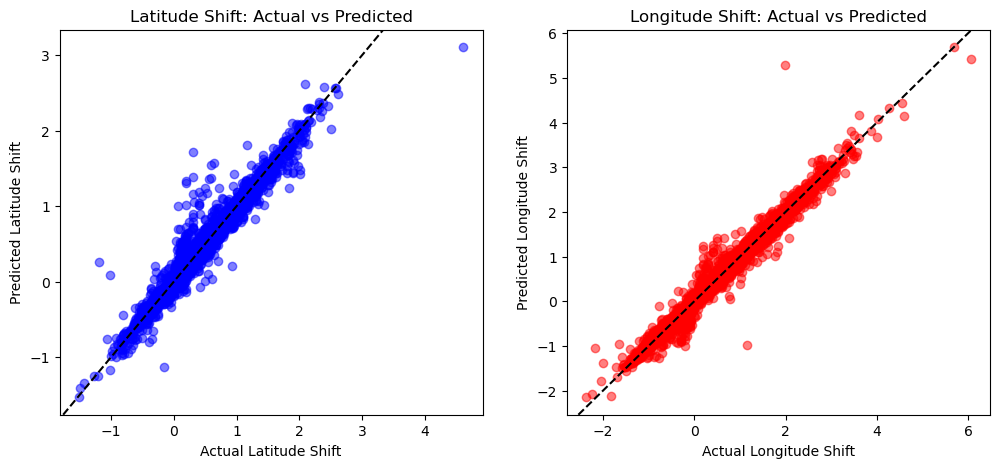

In [22]:
# Scatter plot: Actual vs. Predicted Latitude Shift
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test_lat, y_pred_lat_tuned, alpha=0.5, color="blue")
plt.axline((0, 0), slope=1, color="black", linestyle="--")  # Reference y = x line
plt.xlabel("Actual Latitude Shift")
plt.ylabel("Predicted Latitude Shift")
plt.title("Latitude Shift: Actual vs Predicted")

# Scatter plot: Actual vs. Predicted Longitude Shift
plt.subplot(1, 2, 2)
plt.scatter(y_test_lon, y_pred_lon_tuned, alpha=0.5, color="red")
plt.axline((0, 0), slope=1, color="black", linestyle="--")  # Reference y = x line
plt.xlabel("Actual Longitude Shift")
plt.ylabel("Predicted Longitude Shift")
plt.title("Longitude Shift: Actual vs Predicted")

plt.show()

## **What Do These Plots Show?**
The scatter plots compare the **actual hurricane shifts** (latitude and longitude) with the **model’s predicted values**.  
The dashed black line (y = x) represents a **perfect prediction**.

- **Closer clustering** around the black line = **Higher accuracy**  
- **More spread** = **Higher error**

- **Latitude shifts** are predicted more accurately.  
  The latitude scatter plot is tightly clustered, indicating **high precision**.

- **Longitude shifts** show slightly more variability.  
  The longitude plot has more **spread** and **outliers**, meaning predictions are less stable.

- Both models perform well, but **outliers** exist.  
  The model works well overall, but handling extreme cases can be improved.

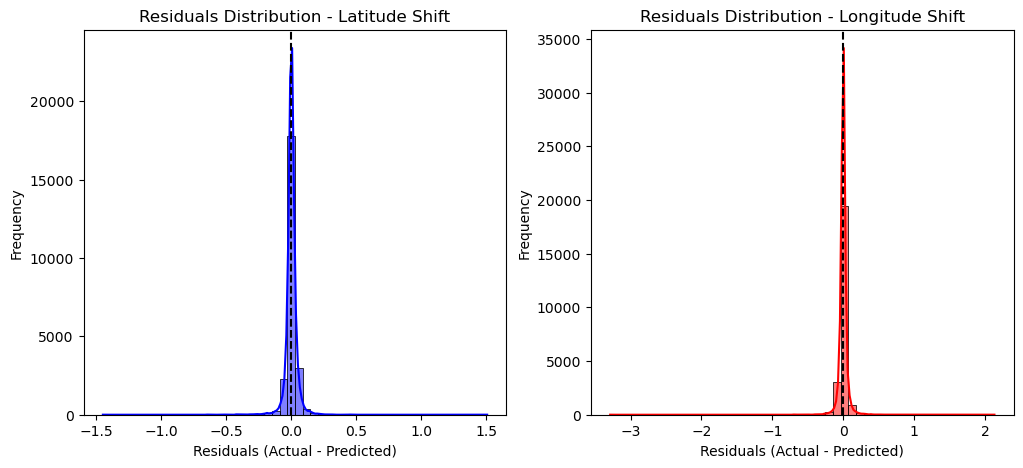

In [23]:
# Residuals (Errors)
lat_residuals = y_test_lat - y_pred_lat_tuned
lon_residuals = y_test_lon - y_pred_lon_tuned

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(lat_residuals, bins=50, kde=True, color="blue")
plt.axvline(0, color='black', linestyle="--")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution - Latitude Shift")

plt.subplot(1, 2, 2)
sns.histplot(lon_residuals, bins=50, kde=True, color="red")
plt.axvline(0, color='black', linestyle="--")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.title("Residuals Distribution - Longitude Shift")

plt.show()

## **What Are Residuals?**
Residuals represent the difference between **actual** and **predicted values**:  
**Residual = Actual − Predicted**

A perfect model would have residuals **centered around 0** with minimal spread.  
This plot helps assess if errors are **randomly distributed** or if there's a pattern.


## **Left Plot: Residuals Distribution for Latitude Shift (Blue)**

- Most residuals are **centered around 0**, indicating **low error** in predicting latitude shifts.
- The **narrow distribution** suggests the model consistently predicts **accurate latitude shifts**.
- Few small deviations on both sides, indicating **minor underestimation** and **overestimation** in extreme cases.

**Conclusion**: The model performs **very well** for latitude predictions with only **minor deviations**.

## **Right Plot: Residuals Distribution for Longitude Shift (Red)**

- Most residuals are **concentrated around 0**, indicating **accurate longitude shift predictions**.
- A **slightly wider spread** than latitude residuals suggests more **variability** in longitude shift errors.
- A few more **extreme residuals** (larger deviations from 0) compared to latitude.

**Conclusion**: The model is **highly accurate** for longitude shifts but has **slightly higher error variance** than for latitude shifts.

# 7. Model Prediction Example: Hurricane Track Simulation

To further validate our model's effectiveness, we generate a real-world prediction example. Given an initial hurricane position and movement history, the model predicts the next latitude and longitude shift.

 **Hurricane Track Prediction Example**
Initial Latitude: 14.960026741027832
Initial Longitude: -64.19970703125

 **Predicted Shift**: (ΔLat: 0.0678, ΔLon: -0.8106)
 **Actual Shift**: (ΔLat: 0.1400, ΔLon: -0.8003)


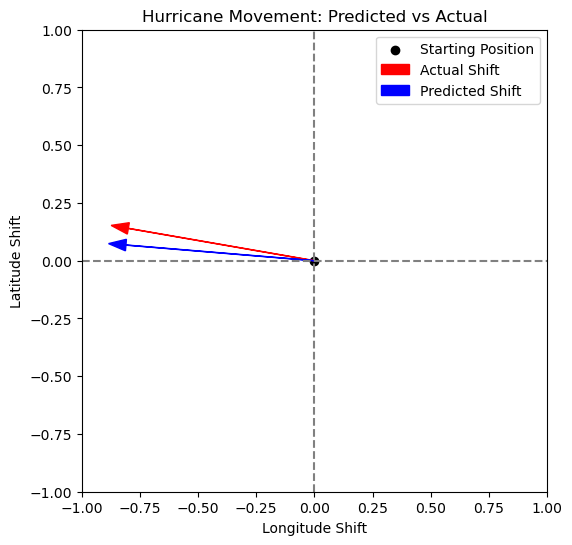

In [25]:
import numpy as np

# Select a random hurricane track for testing
random_index = np.random.randint(0, X_test.shape[0])

# Extract the test feature vector
sample_features = X_test[random_index].reshape(1, -1)

# Model prediction
predicted_lat_shift = xgb_best_lat.predict(sample_features)[0]
predicted_lon_shift = xgb_best_lon.predict(sample_features)[0]

# Retrieve actual values for comparison
actual_lat_shift = y_test_lat[random_index]
actual_lon_shift = y_test_lon[random_index]

# Display results
print(f" **Hurricane Track Prediction Example**")
print(f"Initial Latitude: {X_test[random_index][0]}")
print(f"Initial Longitude: {X_test[random_index][1]}")
print(f"\n **Predicted Shift**: (ΔLat: {predicted_lat_shift:.4f}, ΔLon: {predicted_lon_shift:.4f})")
print(f" **Actual Shift**: (ΔLat: {actual_lat_shift:.4f}, ΔLon: {actual_lon_shift:.4f})")

# Visualization of actual vs predicted movement
plt.figure(figsize=(6, 6))
plt.scatter(0, 0, color='black', marker='o', label='Starting Position')
plt.arrow(0, 0, actual_lon_shift, actual_lat_shift, color='red', head_width=0.05, label='Actual Shift')
plt.arrow(0, 0, predicted_lon_shift, predicted_lat_shift, color='blue', head_width=0.05, label='Predicted Shift')

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.xlabel("Longitude Shift")
plt.ylabel("Latitude Shift")
plt.legend()
plt.title("Hurricane Movement: Predicted vs Actual")
plt.show()


- The **black point** represents the **starting position** of the hurricane.
- The **red arrow** shows the **actual shift** in latitude and longitude.
- The **blue arrow** represents the model’s **predicted shift**.

If the **blue** and **red arrows** are closely aligned, the model **successfully predicted** the next hurricane movement.

## **Summary of Prediction Results**:

- **Longitude shift prediction** (-0.8106) closely matches **actual** (-0.8003) → Model accurately captures **westward movement**.
- **Latitude shift prediction** (0.0678) is slightly lower than **actual** (0.1400) → Model **underestimates** **northward movement**.

Overall, predictions align well with **actual movement**, with minor deviation in **latitude**.


# 8. Conclusion & Discussion

In [26]:
from IPython.display import display, Markdown

# Summary of Model Performance
summary_text = """
##  Conclusion & Discussion

### **1️. Key Findings**
- Our **XGBoost model successfully predicts hurricane trajectory shifts** (latitude and longitude changes).
- **Evaluation Metrics**:
  - **Mean Absolute Error (MAE)**:
    - Latitude Shift: **0.0266°**
    - Longitude Shift: **0.0336°**
  - **R² Scores**:
    - Latitude Shift: **0.9736** (97.36% variance explained)
    - Longitude Shift: **0.9898** (98.98% variance explained)
- **Interpretation**:
  - The model has **high predictive accuracy**.
  - Scatter plots show a strong **correlation** between actual and predicted values.
  - Residuals are well-distributed around **zero**, indicating no bias.

---

### **2️. Model Strengths**
 **High Predictive Power**: The model accurately predicts hurricane shifts.  
 **Minimal Error**: The low MAE values indicate that predictions are very close to actual shifts.  
 **No Systematic Bias**: Residual analysis shows a **balanced distribution of errors**.  

---

### **3️. Model Limitations & Future Improvements**
 **Handling Outliers**:
- Some **outliers** in scatter plots suggest **prediction errors in extreme cases**.
- Possible solution: **Using ensemble models** or integrating **other meteorological factors** (e.g., pressure changes, wind shear).

 **Feature Expansion**:
- Current features include **storm speed, direction, seasonality, and ENSO effects**.
- Adding **atmospheric pressure, humidity levels, and ocean temperature data** may further improve predictions.

 **Testing Other ML Models**:
- XGBoost performs well, but other models such as **LSTMs (Long Short-Term Memory)** for sequential data might improve results.
- Future work could involve **deep learning approaches** for capturing complex temporal dependencies.

---

### **4️. Final Thoughts**
 **This study provides an effective machine learning approach for predicting hurricane track movements.**  
 **Further refinements with additional data and advanced modeling techniques can enhance accuracy even more.**  
 **This model can be integrated into early warning systems for better hurricane trajectory forecasting.**

"""

# Display conclusion
display(Markdown(summary_text))



##  Conclusion & Discussion

### **1️. Key Findings**
- Our **XGBoost model successfully predicts hurricane trajectory shifts** (latitude and longitude changes).
- **Evaluation Metrics**:
  - **Mean Absolute Error (MAE)**:
    - Latitude Shift: **0.0266°**
    - Longitude Shift: **0.0336°**
  - **R² Scores**:
    - Latitude Shift: **0.9736** (97.36% variance explained)
    - Longitude Shift: **0.9898** (98.98% variance explained)
- **Interpretation**:
  - The model has **high predictive accuracy**.
  - Scatter plots show a strong **correlation** between actual and predicted values.
  - Residuals are well-distributed around **zero**, indicating no bias.

---

### **2️. Model Strengths**
 **High Predictive Power**: The model accurately predicts hurricane shifts.  
 **Minimal Error**: The low MAE values indicate that predictions are very close to actual shifts.  
 **No Systematic Bias**: Residual analysis shows a **balanced distribution of errors**.  

---

### **3️. Model Limitations & Future Improvements**
 **Handling Outliers**:
- Some **outliers** in scatter plots suggest **prediction errors in extreme cases**.
- Possible solution: **Using ensemble models** or integrating **other meteorological factors** (e.g., pressure changes, wind shear).

 **Feature Expansion**:
- Current features include **storm speed, direction, seasonality, and ENSO effects**.
- Adding **atmospheric pressure, humidity levels, and ocean temperature data** may further improve predictions.

 **Testing Other ML Models**:
- XGBoost performs well, but other models such as **LSTMs (Long Short-Term Memory)** for sequential data might improve results.
- Future work could involve **deep learning approaches** for capturing complex temporal dependencies.

---

### **4️. Final Thoughts**
 **This study provides an effective machine learning approach for predicting hurricane track movements.**  
 **Further refinements with additional data and advanced modeling techniques can enhance accuracy even more.**  
 **This model can be integrated into early warning systems for better hurricane trajectory forecasting.**

